In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Visualize Data Sample

high-level command: tensor([0, 0, 0, 1])


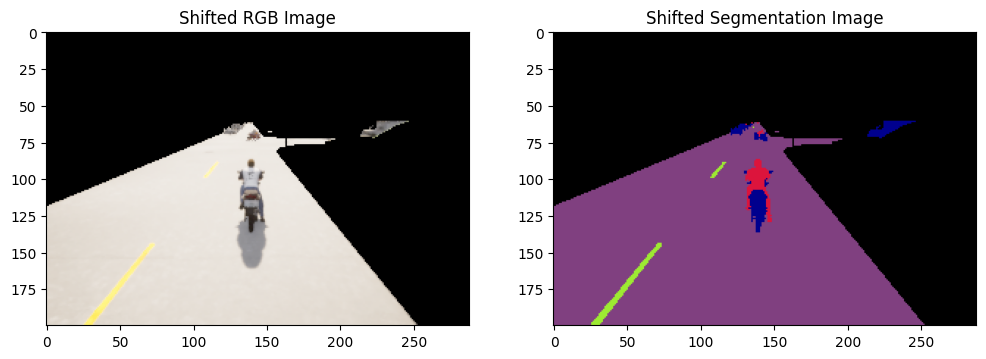

In [5]:
import matplotlib.pyplot as plt
from utils.load_dataset import CARLADataset
from torchvision.transforms import Compose
from utils.preprocess import FilterClassesTransform, ShiftAndAdjustSteer

# Instantiate the transformations
filter_transform = FilterClassesTransform(mode='both')
shift_transform = ShiftAndAdjustSteer(shift_fraction=0.1, steer_adjust=1.0)

# Compose the transformations
# transforms = Compose([
#     ApplyToSample(filter_transform), 
#     ApplyToSample(shift_transform)
# ])
transforms = Compose([filter_transform, shift_transform])

# Instantiate the dataset
dataset = CARLADataset('../data/noisy_data_tm/train', transform=transforms)

# Choose a sample index
sample_idx = 1400

# Fetch the sample data
images, speed, hlc, controls = dataset[sample_idx]
print(f'high-level command: {hlc}')
rgb = images[:3, :, :].permute(1, 2, 0)
segmentation = images[3:, :, :].permute(1, 2, 0)

# Plot the original RGB image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
#print(rgb.shape)
plt.imshow(rgb)
plt.title('Shifted RGB Image')

# Plot the filtered segmentation image
plt.subplot(1, 2, 2)
plt.imshow(segmentation)
plt.title('Shifted Segmentation Image')

plt.show()

number of frames: 888
Frame number: [0]
Controls: [ 0.85000002 -0.01688435  0.        ]
Measurements: [9.67883022]
[[[ 42  34  28]
  [ 38  28  28]
  [ 46  34  34]
  ...
  [ 22  22  13]
  [ 13  22  13]
  [ 13  22  13]]

 [[ 71  61  42]
  [ 59  61  34]
  [ 50  38  28]
  ...
  [ 13  13   0]
  [ 13  13   0]
  [ 13  22  13]]

 [[105  98  77]
  [ 59  56  38]
  [ 34  22  22]
  ...
  [ 22  22  13]
  [ 13  13   0]
  [ 50  46  22]]

 ...

 [[225 217 207]
  [225 218 208]
  [226 219 210]
  ...
  [200 189 174]
  [197 185 171]
  [193 182 168]]

 [[226 219 209]
  [226 218 209]
  [226 219 209]
  ...
  [197 186 173]
  [201 189 175]
  [192 180 166]]

 [[228 220 211]
  [225 217 208]
  [225 217 207]
  ...
  [201 190 177]
  [200 189 175]
  [193 181 167]]]


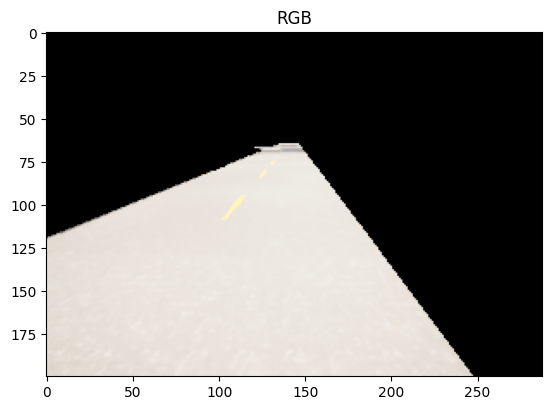

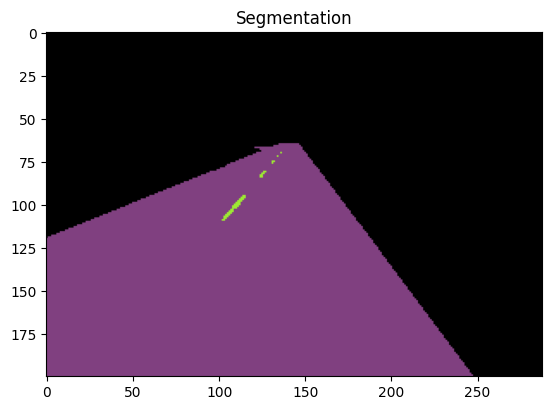

In [9]:

import matplotlib.pyplot as plt
from utils.load_dataset import CARLADataset
from torchvision.transforms import Compose
from utils.preprocess import FilterClassesTransform, ShiftAndAdjustSteer
    
def filter_classes(rgb, seg, classes_to_keep=[4, 6, 7, 10]):
    classes = {
            0: [0, 0, 0],         # Unlabeled
            1: [70, 70, 70],      # Buildings
            2: [100, 40, 40],     # Fences
            3: [55, 90, 80],      # Other
            4: [220, 20, 60],     # Pedestrians
            5: [153, 153, 153],   # Poles
            6: [157, 234, 50],    # RoadLines
            7: [128, 64, 128],    # Roads
            8: [244, 35, 232],    # Sidewalks
            9: [107, 142, 35],    # Vegetation
            10: [0, 0, 142],      # Vehicles
            11: [102, 102, 156],  # Walls
            12: [220, 220, 0],    # TrafficSigns
            13: [70, 130, 180],   # Sky
            14: [81, 0, 81],      # Ground
            15: [150, 100, 100],  # Bridge
            16: [230, 150, 140],  # RailTrack
            17: [180, 165, 180],  # GuardRail
            18: [250, 170, 30],   # TrafficLight
            19: [110, 190, 160],  # Static
            20: [170, 120, 50],   # Dynamic
            21: [45, 60, 150],    # Water
            22: [145, 170, 100],  # Terrain
        }

    classes_to_keep_rgb = np.array([classes[class_id] for class_id in classes_to_keep])

    # Create a mask of pixels to keep
    mask = np.isin(seg, classes_to_keep_rgb).all(axis=-1)

    # Initialize filtered images as black images
    filtered_seg = np.zeros_like(seg)
    filtered_rgb = np.zeros_like(rgb)

    # Use the mask to replace the corresponding pixels in the filtered images
    filtered_seg[mask] = seg[mask]
    filtered_rgb[mask] = rgb[mask]

    return filtered_rgb, filtered_seg

import h5py
import numpy as np
import matplotlib.pyplot as plt

# Open the HDF5 file
file = h5py.File('../data/noisy_data_tm/train/episode_30.hdf5', 'r')

# Get the number of frames
num_frames = file['frame'].shape[0]
print(f'number of frames: {num_frames}')

# If there are frames, print some of the data of the first frame
i = 0
if num_frames > 0:
    # Print frame number, controls, and measurements
    print(f"Frame number: {file['frame'][i]}")
    print(f"Controls: {file['controls'][i]}")
    print(f"Measurements: {file['measurements'][i]}")
    
    # Visualize RGB image
    filtered_rgb, filtered_seg = filter_classes(file['rgb'][i], file['segmentation'][i])
    plt.imshow(filtered_rgb)
    print(file['rgb'][i])

    plt.title('RGB')
    plt.show()
    
    # Visualize Segmetation image
    segmentation = file['segmentation'][i]
    plt.imshow(filtered_seg)
    plt.title('Segmentation')
    plt.show()

file.close()

## Load Dataset

In [10]:
from utils.load_dataset import CARLADataset
from torch.utils.data import DataLoader

def load_data(batch_size, dataset_path, transform):
    train_data_dir = f"{dataset_path}train"
    val_data_dir = f"{dataset_path}val"

    train_dataset = CARLADataset(train_data_dir, transform=transform)
    val_dataset = CARLADataset(val_data_dir, transform=transform)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

    return train_dataloader, val_dataloader

## Train Model

In [12]:

def train_model(model, train_dataloader, val_dataloader, epochs, device):
    # loss function and optimizer
    criterion = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters())

    # torch.autograd.set_detect_anomaly(True)

    train_losses = []
    val_losses = []
    # loop over the dataset

    for epoch in range(epochs):
        model.train()

        running_loss = 0.0

        # Training loop
        for i, data in enumerate(train_dataloader):
            # Get the inputs and move them to the appropriate device (CPU or GPU)
            img, speed, hlc, controls = data
            img = img.to(device)
            speed = speed.to(device)
            hlc = hlc.to(device)
            controls = controls.to(device)

            # forward pass
            outputs = model(img, speed, hlc)
            loss = criterion(outputs, controls)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()

            if i % 200 == 199:  # Print every 200 mini-batches
                print(f'Epoch: {epoch + 1}, Batch: {i + 1}')
        
        # compute average loss
        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)

        # validation
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(val_dataloader):
                img, speed, hlc, controls = data
                img = img.to(device)
                speed = speed.to(device)
                hlc = hlc.to(device)
                controls = controls.to(device)

                outputs = model(img, speed, hlc)
                loss = criterion(outputs, controls)

                running_loss += loss.item()
        
        # Compute the average loss
        val_loss = running_loss / len(val_dataloader)
        val_losses.append(val_loss)
        

        # print statistics
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # save model
        torch.save(model.state_dict(), f'model_checkpoint_{epoch}.pth')
    
    # save the losses for analysis
    torch.save({'train_losses': train_losses, 'val_losses': val_losses}, 'losses.pth')

In [15]:
from utils.ModifiedDeepestLSTMTinyPilotNet import DeepestLSTMTinyPilotNet, DeepestLSTMTinyPilotNetOneHot
from torchvision.transforms import Compose
from utils.preprocess import FilterClassesTransform, ShiftAndAdjustSteer

# Instantiate the transformations
filter_transform = FilterClassesTransform(mode='both')
shift_transform = ShiftAndAdjustSteer(shift_fraction=0.1, steer_adjust=1.0)
transforms = Compose([filter_transform, shift_transform])

# Set the batch size and number of epochs
batch_size = 32
epochs = 10
 
#transform = FilterClassesTransform(mode='both')
transform = None
hlc_one_hot = True
# Load the data
train_dataloader, val_dataloader = load_data(batch_size, '../data/noisy_data_tm/', transform=transforms, hlc_one_hot=hlc_one_hot)
print("loaded data")

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize the model and move it to the device
# model = DeepestLSTMTinyPilotNet((288, 200, 6), 3, 4)
model = DeepestLSTMTinyPilotNetOneHot((288, 200, 6), 3, 4)
#model.load_state_dict(torch.load("model_checkpoint_19.pth"))
model.to(device)

# Train the model
train_model(model, train_dataloader, val_dataloader, epochs, device)


ImportError: cannot import name 'DeepestLSTMTinyPilotNet' from 'utils.ModifiedDeepestLSTMTinyPilotNet' (/home/meiqi/carla-examples/ModifiedDeepestLSTMTinyPilotNet/utils/ModifiedDeepestLSTMTinyPilotNet.py)

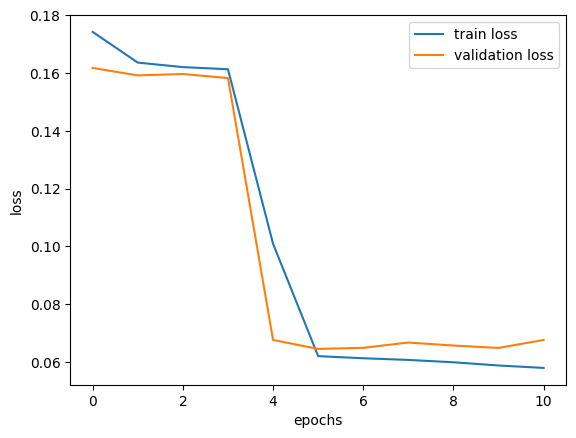

In [5]:
import matplotlib.pyplot as plt
train_losses = [0.17419023024426264, 0.16357032273711314, 0.16201415958560325, 0.161272619208244, 0.10086857413917333, 0.061997290242228595, 0.061262751327181036, 0.06068882600390853, 0.05986840605123877, 0.058763292711420556, 0.0579179573595723]
val_losses = [0.1617148632050892, 0.15914982609333, 0.1596264310328881, 0.15822351896896, 0.06759180002393488, 0.06450492420368668, 0.06487088243584112, 0.06670292538463794, 0.06566338530280179, 0.06483659671757924, 0.06759286151941067]
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Plot losses

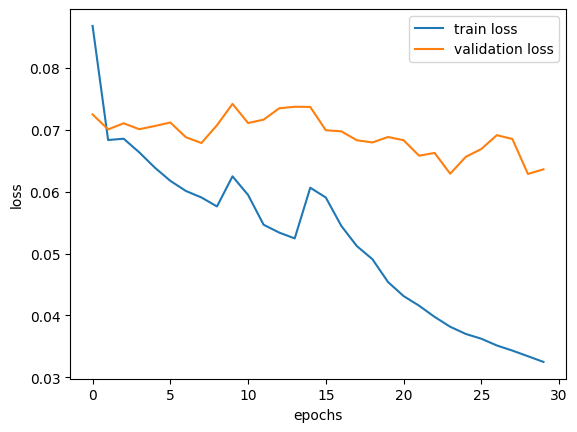

In [5]:
# Load the tensor from the file
loss_history = torch.load('models/v6.0_losses.pth')

# Now you can use this tensor, print it, plot it, etc.
train_l1 = loss_history['train_losses']
val_l1 = loss_history['val_losses']

# # Load the tensor from the file
# loss_history2 = torch.load('losses.pth')

# # # Now you can use this tensor, print it, plot it, etc.
# train_l2 = loss_history2['train_losses']
# val_l2 = loss_history2['val_losses']

train_losses = train_l1
val_losses = val_l1

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Predictions Visualization

Sample 1
True controls: throttle 0.75, brake 0.0, steer 0.5000001788139343
Predicted controls: throttle 0.4693906605243683, brake 0.019838115200400352, steer 0.5044017434120178

Sample 2
True controls: throttle 0.75, brake 0.0, steer 0.49999043345451355
Predicted controls: throttle 0.4670695960521698, brake 0.02012774907052517, steer 0.5043944716453552

Sample 3
True controls: throttle 0.75, brake 0.0, steer 0.5000007152557373
Predicted controls: throttle 0.46845924854278564, brake 0.019953815266489983, steer 0.5043988227844238

Sample 4
True controls: throttle 0.75, brake 0.0, steer 0.5000011920928955
Predicted controls: throttle 0.47228723764419556, brake 0.019482610747218132, steer 0.5044108629226685



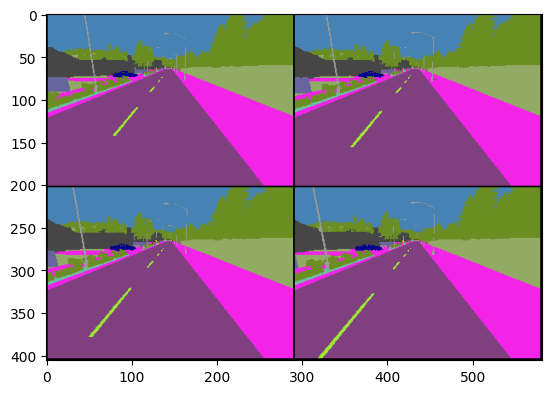

In [70]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepestLSTMTinyPilotNet((288, 200, 6), 3)
model.load_state_dict(torch.load("model_checkpoint_99.pth"))
model = model.to(device)
model.eval()

# Load the validation dataset
val_dataset = CARLADataset("../data/train/")
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

# Get a batch of validation data
dataiter = iter(val_dataloader)
num_batches = len(val_dataloader)
selected_batch = random.randint(0, 100)

for i in range(selected_batch):
    data = next(dataiter)
images, speeds, controls_true = data

# Predict controls with the model
controls_pred = model(images.to(device), speeds.to(device))


# Convert tensors to numpy arrays for printing
with torch.no_grad():
    controls_true = controls_true.numpy()
    controls_pred = controls_pred.cpu().detach().numpy()

# Print true and predicted controls for each sample
for i in range(4):
    print(f"Sample {i+1}")
    print(f"True controls: throttle {controls_true[i, 0]}, brake {controls_true[i, 2]}, steer {controls_true[i, 1]}")
    print(f"Predicted controls: throttle {controls_pred[i, 0]}, brake {controls_pred[i, 2]}, steer {controls_pred[i, 1]}")
    print()

# Display images
segmentation_images = images[:, 3:, :, :]
grid_img = make_grid(segmentation_images, nrow=2)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(dataset):
    throttle_vals = []
    brake_vals = []
    steer_vals = []
    speed_vals = []

    for _, speed, controls in dataset:
        throttle_vals.append(controls[0].item())
        brake_vals.append(controls[2].item())
        steer_vals.append(controls[1].item())
        speed_vals.append(speed.item())

    fig, axs = plt.subplots(2, 2, figsize=(10,10))

    axs[0, 0].hist(throttle_vals, bins=100)
    axs[0, 0].set_title('Throttle')

    axs[0, 1].hist(brake_vals, bins=100)
    axs[0, 1].set_title('Brake')

    axs[1, 0].hist(steer_vals, bins=100)
    axs[1, 0].set_title('Steer')

    axs[1, 1].hist(speed_vals, bins=100)
    axs[1, 1].set_title('Speed')

    plt.show()



## Dataset Analysis

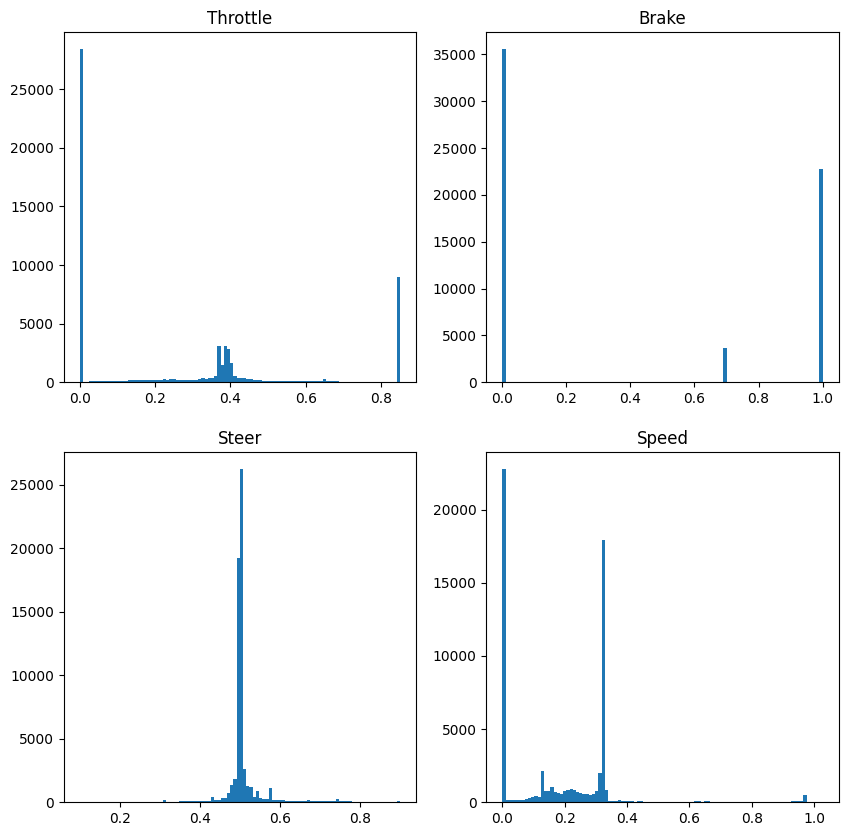

In [7]:
from utils.load_dataset import CARLADataset
dataset = CARLADataset("../data/noisy_data_tm/train")
plot_histogram(dataset)

4093
Frame number: [0]
Controls: [ 0.85000002 -0.00625137  0.        ]
Measurements: [9.67924921]
uint8


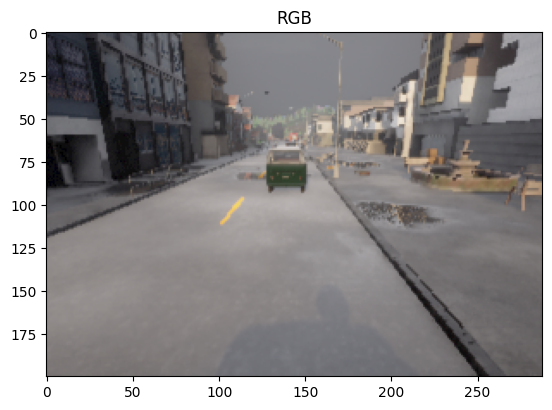

uint8
(200, 288, 3)


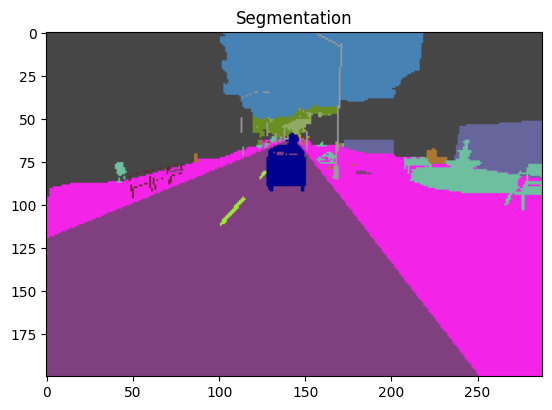

In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Open the HDF5 file
file = h5py.File('../data/noisy_data_tm/train/episode_1.hdf5', 'r')

# Get the number of frames
num_frames = file['frame'].shape[0]
print(num_frames)

# If there are frames, print some of the data of the first frame
i = 0
if num_frames > 0:
    # Print frame number, controls, and measurements
    print(f"Frame number: {file['frame'][i]}")
    print(f"Controls: {file['controls'][i]}")
    print(f"Measurements: {file['measurements'][i]}")
    
    # Visualize RGB image
    plt.imshow(file['rgb'][i])
    print(file['rgb'][i].dtype)
    plt.title('RGB')
    plt.show()
    
    # Visualize Segmetation image
    segmentation = file['segmentation'][i]
    print(segmentation.dtype)
    print(segmentation.shape)
    plt.imshow(segmentation)
    plt.title('Segmentation')
    plt.show()

file.close()
